# SPD preconditioning

In [1]:
using FundamentalsNumericalComputation

First we create a large, sparse, positive definite matrix that arises in the solution of differntial equations.

In [2]:
k = 200
D2 = spdiagm(0=>fill(2,k-1),1=>-ones(k-2),-1=>-ones(k-2))
IA = spdiagm(0=>ones(k-1))
A = kron(IA,D2) + kron(D2,IA);
@show n = size(A,1);
@show nnz(A);

n = size(A, 1) = 39601
nnz(A) = 197209


Now we solve a linear system with a random right-hand side, without preconditioner.

In [3]:
b = rand(size(A,1))
cg(A,b,maxiter=4,reltol=1e-10,log=true);  # force compilation before timing
time_plain = @elapsed x,hist1 = cg(A,b,maxiter=400,reltol=1e-10,log=true);
@show time_plain;

time_plain = 0.121446385


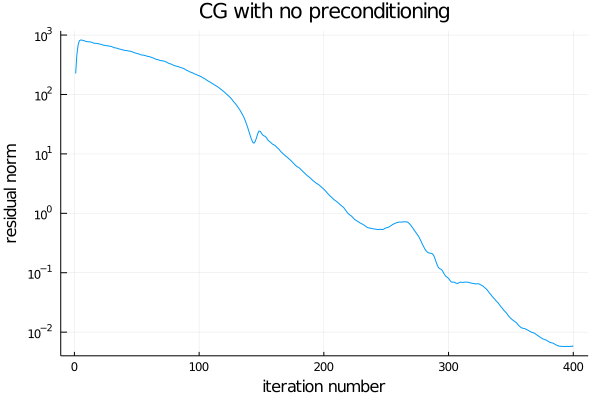

In [4]:
plot(hist1[:resnorm],label="", 
    title="CG with no preconditioning",
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )

For an SPD matrix we can use an incomplete Cholesky factorization, in which some of the factor's elements are dropped to maintain sparsity.

In [5]:
P = CholeskyPreconditioner(A,20);
L = P.L;
@show nnz(L);

nnz(L) = 428470


In [10]:
typeof(P)

CholeskyPreconditioner{Float64, SparseMatrixCSC{Float64, Int64}}

In [11]:
i,j,v = findnz(L)
R = UpperTriangular(sparse(j,i,v));
ldiv!(y,::typeof(P),x) = ldiv!(y,R,L\x);

In [7]:
precond = x -> R\(L\x);

Now we apply CG using this preconditioner. 

In [13]:
cg(A,b,Pl=P,maxiter=4,reltol=1e-10,log=true);  # force compilation before timing
time_prec = @elapsed x,hist2 = cg(A,b,Pl=P,maxiter=400,reltol=1e-10,log=true);
@show time_prec;
@show speedup = time_plain / time_prec;

LoadError: InterruptException:

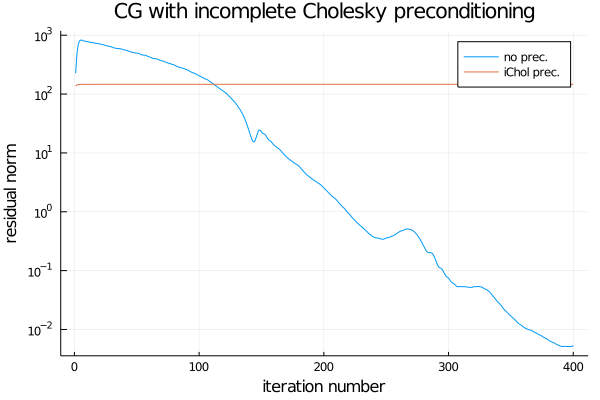

In [67]:
plot(hist1[:resnorm],label="no prec.", 
    xaxis=("iteration number"), yaxis=(:log10,"residual norm"),
    title="CG with incomplete Cholesky preconditioning")
plot!(hist2[:resnorm],label="iChol prec.")

You can see we got a little improvement with this preconditioner. It saved enough iterations to more than make up for the fact that each iteration now involves extra work.

In [36]:
eigs(A,nev=4,which=:SM)

([0.0019737585370736515, 0.004933422411993618, 0.00493342241199365, 0.007893086286913637], [1.973271571728436e-5 -9.452938096495035e-6 5.4978260317050875e-5 -7.885298685522172e-5; 3.9445957626515174e-5 -1.8801199939174485e-5 0.00010983489390299071 -0.00015739477699582805; … ; 3.94459576265151e-5 1.8801199939174316e-5 -0.00010983489390298925 -0.00015739477699582566; 1.9732715717284074e-5 9.45293809649451e-6 -5.497826031704997e-5 -7.885298685522064e-5], 4, 2, 36, [-0.0038196414348328463, -0.039372383913396564, 0.04191050228772723, 0.0506910626021113, -0.03655377503493816, 0.022607575069573605, -0.07670586360248328, -0.12248204708715026, 0.013651174008168903, -0.05614763581067262  …  -0.008610210218413017, 0.036723278989070435, 0.008636384797602967, 0.0205173529609447, 0.06800814132702183, 0.09142649563724393, 0.08356072728902894, 0.11532800557067469, 0.11254990829485341, 0.034069271838719196])

In [48]:
@elapsed P.L\b

0.023652032

In [80]:
nz = findnz(L);
R = UpperTriangular(sparse(nz[2],nz[1],nz[3]));

In [84]:
?transpose

search: transpose transpose! Transpose copy_transpose! TransparentColor



```
A'ᵀ
transpose(A)
```

Lazy transpose. Mutating the returned object should appropriately mutate `A`. Often, but not always, yields `Transpose(A)`, where `Transpose` is a lazy transpose wrapper. Note that this operation is recursive.

This operation is intended for linear algebra usage - for general data manipulation see [`permutedims`](@ref Base.permutedims), which is non-recursive.

!!! compat "Julia 1.6"
    The postfix operator `'ᵀ` requires Julia 1.6.


# Examples

```jldoctest
julia> A = [3+2im 9+2im; 8+7im  4+6im]
2×2 Matrix{Complex{Int64}}:
 3+2im  9+2im
 8+7im  4+6im

julia> transpose(A)
2×2 transpose(::Matrix{Complex{Int64}}) with eltype Complex{Int64}:
 3+2im  8+7im
 9+2im  4+6im

julia> x = [3, 4im]
2-element Vector{Complex{Int64}}:
 3 + 0im
 0 + 4im

julia> x'ᵀx
-7 + 0im
```

---

```
transpose(A::LinearMap)
```

Construct a lazy representation of the transpose of `A`. This can be either a `TransposeMap` wrapper of `A`, or a suitably redefined instance of the same type as `A`. For instance, for a linear combination of linear maps $A + B$, the transpose is given by $A^⊤ + B^⊤$, i.e., another linear combination of linear maps.


In [86]:
?transpose!

search: transpose! copy_transpose! transpose Transpose TransparentColor



```
transpose!(dest,src)
```

Transpose array `src` and store the result in the preallocated array `dest`, which should have a size corresponding to `(size(src,2),size(src,1))`. No in-place transposition is supported and unexpected results will happen if `src` and `dest` have overlapping memory regions.

# Examples

```jldoctest
julia> A = [3+2im 9+2im; 8+7im  4+6im]
2×2 Matrix{Complex{Int64}}:
 3+2im  9+2im
 8+7im  4+6im

julia> B = zeros(Complex{Int64}, 2, 2)
2×2 Matrix{Complex{Int64}}:
 0+0im  0+0im
 0+0im  0+0im

julia> transpose!(B, A);

julia> B
2×2 Matrix{Complex{Int64}}:
 3+2im  8+7im
 9+2im  4+6im

julia> A
2×2 Matrix{Complex{Int64}}:
 3+2im  9+2im
 8+7im  4+6im
```
